In [ ]:
### Claen variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
# forecast monthly births with xgboost
import time
# import lybraries
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
#from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


In [ ]:
### read data
#df = read_csv('data_29sites_short.csv', header=0, index_col=0)       # <------- READ DATA
# From:  # From: D:\research\ML_model\new_data\050_spatial_data_no_normal_29sites.csv
df = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)       # <------- READ DATA
heads_n = list(df.columns.values) # Get head names
print ("head-names:", heads_n) # print all the headers (variable names)
#head-names: ['id', 'site', 'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF', 'W_area',
# 'W_elev', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET',
#'CROP', 'SRB', 'Tr_hr', 'Tr_hl', 'NDVI', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c',
# 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150', 'Tw']

### Remove columns
#d1 = d1.drop(['hg_c', 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150'],axis=1)

### Select columns
# General    2V: 'id', 'site'
# Weather    7V: 'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF'
# Watershed  3V: 'W_area', 'W_elev', 'W_slp'
# Stream     5V: 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins'
# LandCover  8V: 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'Tr_hr', 'Tr_hl', 'NDVI'
# Site       4V: 'S_Lat', 'S_Long', 'S_elev', 'S_mar'
# Soil       4V: 'hg_c', 'hg_d', 'hg_b', 'hg_cd'
# Drainage   5V: 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150'

df1 = df[['id','site'
         ,'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF'
         ,'W_area', 'W_elev', 'W_slp'
         ,'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins'
         ,'FRS', 'URB', 'WET', 'CROP', 'SRB'#, 'Tr_hr', 'Tr_hl', 'NDVI'
         ,'S_Lat', 'S_Long', 'S_elev', 'S_mar'
         ,'hg_c', 'hg_d', 'hg_b', 'hg_cd'
         ,'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150'
         , 'Tw'  # REsponse variable
         ]]

heads_df1 = list(df1.columns.values)
print ("head-after-removing:", heads_df1) # print all the headers (variable names)

#print ("n_of X_variables:",len(heads_n)-3, "   y_variables:",1)
#print (df1.columns.values[2:]) # To no-show 'id' & ' site'
print (df1.shape) #print (heads_n)

### Remove sites
#d1 = d1[d1.id != 14] # Remove the row with id = 1
#print (d1.shape)


head-names: ['id', 'site', 'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF', 'W_area', 'W_elev', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'Tr_hr', 'Tr_hl', 'NDVI', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c', 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150', 'Tw']
head-after-removing: ['id', 'site', 'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF', 'W_area', 'W_elev', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c', 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150', 'Tw']
(2407, 36)


In [ ]:
#print (d1)
d2 = df1[df1.id != 2] # Remove the row with id = 1
#d2 = d2[d2.id != 4] # Remove the row with id = 1
#d2 = d2[d2.id != 6] # Remove the row with id = 1
#d1 = d2
print (d2.shape) #print (heads_n)

(2324, 38)


In [ ]:
def setting_vars(d1, site): # d1: DDBB; site: site to be removed
  ### Separate one site for test. Leave-one-out site
  site = site #9   #  <----------------------------------  SET
  train = d1[d1.id != site] # Remove the row with id = 1
  test = d1[d1.id == site]  # Select the row with id = 1

  #print (train)

  ### Removing colums 'id' & 'site'
  train,test = train.drop(['id', 'site'], axis=1),test.drop(['id', 'site'], axis=1)
  final_vars = list(train.columns.values)
  print ("Preditors and Response variables \n", list(train.columns.values))

  ### Convert panda to numpay
  train = np.asarray(train, dtype=np.float32) # Convert pandas df to np array
  test = np.asarray(test, dtype=np.float32) # Convert pandas df to np array

  from sklearn.model_selection import train_test_split
  ### Split in predictors and responder
  train_x, train_y = train[:, :-1], train[:, -1]
  test_x, test_y = test[:, :-1], test[:, -1]
  #trainX, tx, trainy, ty = train_test_split(Xs, Ys, test_size=0.33, random_state=2)
  return train_x, train_y, test_x, test_y

In [ ]:
site = 9   #  <----------------------------------  SET
train = df1[df1.id != site] # Remove the row with id = 1
test = df1[df1.id == site]  # Select the row with id = 1

#print (train)

### Removing colums 'id' & 'site'
train,test = train.drop(['id', 'site'], axis=1),test.drop(['id', 'site'], axis=1)
final_vars = list(train.columns.values)
print ("Preditors and Response variables \n", list(train.columns.values))

### Convert panda to numpay
train = np.asarray(train, dtype=np.float32) # Convert pandas df to np array
test = np.asarray(test, dtype=np.float32) # Convert pandas df to np array

from sklearn.model_selection import train_test_split
### Split in predictors and responder
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
#trainX, tx, trainy, ty = train_test_split(Xs, Ys, test_size=0.33, random_state=2)
#return train_x, train_y, test_x, test_y

Preditors and Response variables 
 ['Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF', 'W_area', 'W_elev', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c', 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150', 'Tw']


6.302,0.165,1.100,0.054,0.088,0.072,0.227,0.298,1.287,3.728,11.475,0.213,0.116,13.825,2.635,0.248,24.057,0.043,0.025,0.024,0.051,0.107,31.804,0.063,0.036,0.048,0.160,0.082,0.023,0.016,0.804,0.035,0.788


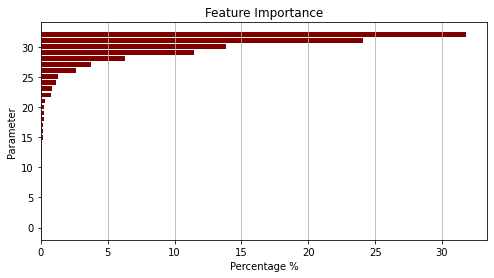

Importance in percentages: 
 [3.18041439e+01 2.40569286e+01 1.38245001e+01 1.14751768e+01
 6.30214787e+00 3.72820878e+00 2.63533711e+00 1.28704715e+00
 1.09992898e+00 8.04480553e-01 7.87911832e-01 2.98226386e-01
 2.48204127e-01 2.26708382e-01 2.12830544e-01 1.64622515e-01
 1.59770072e-01 1.16112225e-01 1.07461877e-01 8.82978588e-02
 8.21543485e-02 7.16331452e-02 6.34700283e-02 5.41165657e-02
 5.13285585e-02 4.76500876e-02 4.25832681e-02 3.62081341e-02
 3.48052792e-02 2.47094072e-02 2.41580475e-02 2.27891374e-02
 1.63462702e-02]


In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(
      objective='reg:squarederror',
      n_estimators = 300,# 100,
      max_depth = 8,  #max_d, # 20,#3
      alpha = 0.1, #alp, #0.1, # L1 regularization
      booster = 'gbtree',
      learning_rate = 0.05, #l_rate, # 0.045439499742861544, # Eta
      gamma = 0.1,
      criterion = 'entropy',
      subsample = 0.90891
      )
#model.fit(train_x, train_y, eval_metric=["rmse"], eval_set=eval_set,verbose=False)
model.fit(train_x, train_y, eval_metric=["rmse"], verbose=False)
f_importance = 100*model.feature_importances_
#print (f_importance)
#print ("Train RMSE:... ", "%.4f" % f_importance)
#dd = return [[round(n, 3) for n in a[0]]]
print(",".join(["{:.3f}".format(item) for item in f_importance]))
sum(f_importance)

import numpy as np
import matplotlib.pyplot as plt
f_importance = 100*model.feature_importances_
sorted_idx = np.argsort(f_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
#plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(axis="x")
plt.xlabel("Percentage %")
plt.ylabel("Parameter")
plt.show()

print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values


In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
### Cross-validation of the model
def find_model  (train_x, train_y, test_x, test_y, site): #(max_d,alp, l_rate):
  #print (l_rate)
  model = XGBRegressor(
      objective='reg:squarederror',
      n_estimators = 300,# 100,
      max_depth = 8,  #max_d, # 20,#3
      alpha = 0.1, #alp, #0.1, # L1 regularization
      booster = 'gbtree',
      learning_rate = 0.05, #l_rate, # 0.045439499742861544, # Eta
      gamma = 0.1,
      criterion = 'entropy',
      subsample = 0.90891
      )

  n_repeats = 5
  cv = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=1)
  scores = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
  # For more scoring metrics see here: https://scikit-learn.org/stable/modules/model_evaluation.html
  #print ("cv_scores",scores)
  print ("Site_predicted:",site)
  print('Mean of neg_root_mean_squared_error: %.3f (%.3f)' % (scores.mean(), scores.std()))

  ### Fit the model and evaluation using train ans test
  eval_set = [(train_x, train_y), (test_x, test_y)]
  model.fit(train_x, train_y, eval_metric=["rmse"], eval_set=eval_set,verbose=False)
  # For metrics of "eval_metric", see here: https://xgboost.readthedocs.io/en/latest/parameter.html


  f_importance = 100*model.feature_importances_
  sorted_idx = np.argsort(f_importance)
  fig = plt.figure(figsize=(8, 4))
  plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
  plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
  plt.title('Feature Importance')
  plt.grid(axis="x")
  plt.xlabel("Percentage %")
  plt.ylabel("Parameter")
  plt.show()

  print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values

  ### Predition
  test_yp = model.predict(test_x)
  return model


In [ ]:
!pip install hydroeval

In [ ]:
def calc_coef (train_x, train_y, test_x, test_y, model, site):
  print ("Site_predicted:",site)
  #print (final_vars)

  from scipy.stats import pearsonr
  ### RMSE & PEarsonR
  #E: By default score calculates the R-squared metric in regression. Ref: https://www.kaggle.com/getting-started/27261
  #E: By default, score computes the accuracy (accuracy = #correct_preds / #all_preds).
  #E: By default, the score method does not need the actual predictions.

  test_yp = model.predict(test_x)

  ### RMSE
  rmse_train = mean_squared_error(train_y, model.predict(train_x))**(1/2.0)
  rmse_test = mean_squared_error(test_y, test_yp)**(1/2.0)
  print ("Train RMSE:... ", "%.4f" % rmse_train, "  Test RMSE:... ", "%.4f" % rmse_test)
  #print("Train R2:..... ", "%.4f" % score, "  Test R2:..... ", "%.4f" % score_2)

  ### Pearson R
  pearson_train,_ = pearsonr(train_y, model.predict(train_x))# Score (r2) For train.
  pearson_test,_ = pearsonr(test_y, test_yp)# Score (r2) For train.
  print('Pearson^2   corr R2: %.4f' % pearson_train, '  corr R2: %.4f' % pearson_test)
  #print('Pearson^2 corr R2: %.4f' % pearson_test)

  ### PBIAS for train
  pred_train_y = model.predict(train_x)
  pred_ytr_flat = pred_train_y.ravel() # Make flat array
  pbias_train = 100.*sum(np.subtract(train_y.tolist(),pred_ytr_flat).tolist())/sum(train_y.tolist()) # 100*Sum(Yobs-Ysim)/Sum(Yobs)
  #print ("PBIAS train:",' %.6f' % pbias_train)
  # PBIAS for test
  pbias_test = 100.*sum(np.subtract(test_y,test_yp).tolist())/sum(test_y.tolist()) # 100*Sum(Yobs-Ysim)/Sum(Yobs)
  #print ("PBIAS test:",' %.4f' % pbias_train)
  print ("Train PBIAS:..",' %.5f' % pbias_train, " Test PBIAS:..",' %.4f' % pbias_test)

  ### NSE
  import hydroeval as he
  nse_train = he.evaluator(he.nse, pred_train_y, train_y)
  nse_test = he.evaluator(he.nse, test_yp, test_y)
  print ("Train NSE:.... ",' %.4f' % nse_train, "  Test NSE:.... ",' %.4f' % nse_test)

  n, k = 83, len(train_x[0])

  sdp1 = np.sum(np.power(train_y - model.predict(train_x), 2))
  AIC_tr = 2*(k+2)-n* ( math.log(2*math.pi) + 1 + math.log(sdp1/n) )

  obs, sim = test_y, test_yp
  dif_pow1 = np.power(obs-sim, 2)
  sdp1 = np.sum(dif_pow1)
  AIC_ts = 2*(k+2)-n* ( math.log(2*math.pi) + 1 + math.log(sdp1/n) )

  ### Appending all coefficients
  all_metrics = [rmse_train, rmse_test, pearson_train, pearson_test, pbias_train, pbias_test,
                 nse_train.tolist()[0], nse_test.tolist()[0], AIC_tr,AIC_ts]
  return all_metrics, test_yp
  #'''

Sites to be tesed removing from the DB: [14]
Site: 14
Preditors and Response variables 
 ['Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF', 'W_area', 'W_elev', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c', 'hg_d', 'hg_b', 'hg_cd', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150', 'Tw']
Site_predicted: 14
Mean of neg_root_mean_squared_error: -0.213 (0.022)


AttributeError: ignored

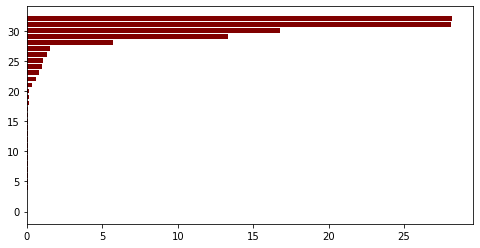

In [ ]:
#print (d1)
import math
sites = [14] #list(range(1, 30))  # set list of 'sites' to remove
#sites.pop(13) # #sites = [9,10]
print ("Sites to be tesed removing from the DB:", sites)
all_st_met = []
for st in sites:
  print ("Site:", st)
  train_x, train_y, test_x, test_y = setting_vars(df1, st)    # ----> Function
  model = find_model (train_x, train_y, test_x, test_y, st) # ----> Function
  metrics,test_yp = calc_coef (train_x, train_y, test_x, test_y, model,st) # ----> Function

  print (len(test_yp.tolist())) # print (test_yp.tolist())
  all_st_met.append(metrics)
  print ()


In [ ]:
# save updated dataset
# 'Tair'
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_8.csv')

In [ ]:
# save updated dataset
#'Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
#'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'crop', 'str_len', 'str_slp', 'hg_c', 'hg_cd',
#'aws_150', 'dc_3', 'dc_1', 'dc_2', 'str_azt', 'tree_hr', 'tree_hl', 'str_wdth', 'str_sins', 'site_mar',
#'site_lat', 'st_long', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_18.csv')

In [ ]:
# save updated dataset
#'Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
#'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'crop', 'str_len', 'str_slp', 'hg_c', 'hg_cd',
#'aws_150', 'dc_3', 'dc_1', 'dc_2', 'str_azt', 'tree_hr', 'tree_hl', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_17.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
# 'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'crop', 'str_len', 'str_slp', 'hg_c', 'hg_cd',
# 'aws_150', 'dc_3', 'dc_1', 'dc_2', 'str_azt', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_16.csv')

In [ ]:
# save updated dataset
#['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
# 'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'crop', 'str_len', 'str_slp', 'hg_c', 'aws_150',
# 'dc_3', 'dc_1', 'dc_2', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_15.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
# 'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'str_len', 'str_slp', 'hg_c', 'aws_150', 'dc_3',
# 'dc_1', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_14.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'forest', 'wtsd_elev',
# 'urban', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'str_len', 'str_slp', 'hg_c', 'aws_150', 'str_wdth',
# 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_13.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'forest', 'wtsd_elev', 'urban',
# 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'str_len', 'str_slp', 'aws_150', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_12.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'wtsd_elev', 'wtrs_slp', 'st_elev', 'wet', 'shrub', 'str_len', 'str_slp', 'aws_150', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_11.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'wtsd_elev', 'wtrs_slp', 'st_elev', 'str_len', 'str_slp', 'aws_150', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_10.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'wtsd_elev', 'st_elev', 'str_len', 'str_slp', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_9.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'st_elev', 'str_len', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_8.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'area', 'forest', 'wtsd_elev', 'st_long', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_7.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'forest', 'wtsd_elev', 'st_elev',
# 'str_len', 'str_slp', 'str_wdth', 'site_lat', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_6.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'area', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_5.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'Prec', 'RH', 'wind', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_4b.csv')

In [ ]:
# save updated dataset
# ['Tair', 'DY', 'SR', 'SF', 'Prec', 'RH', 'wind', 'Tw']
all_st_met_df = pd.DataFrame(all_st_met)
all_st_met_df.to_csv('model_3b.csv')

# of epochs: 300


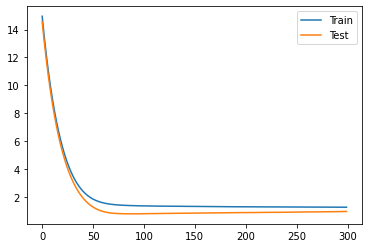

In [ ]:
# Quick plot Learning curve
# retrieve performance metrics
results = model.evals_result()
#epochs = len(results['validation_0']['error'])
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
print ("# of epochs:", epochs)

#plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.show() #'''

Site_predicted: 9
['Tair', 'SR', 'DY', 'SF', 'forest', 'Tw']


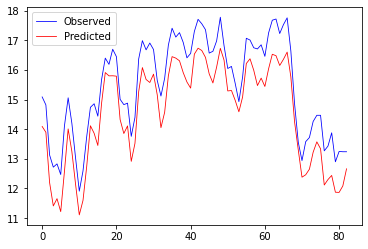

In [ ]:
print ("Site_predicted:",site)
print (final_vars)
### Quick Plot expected vs preducted
from matplotlib.pyplot import figure

test_yp = model.predict(test_x)
x_ax = range(len(test_y))
#plt.scatter(x_ax, ty, s=5, color="blue", label="Observed")
plt.plot(x_ax, test_y, lw=0.8, color="blue", label="Observed")
plt.plot(x_ax, test_yp, lw=0.8, color="red", label="Predicted")
#print (test_y)
#print (test_yp)
plt.legend()
plt.show()

['Tair', 'SR', 'DY', 'SF', 'Prec', 'area', 'Tw']


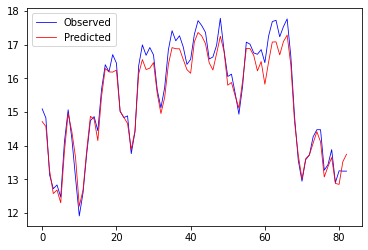

In [ ]:
# Site 9
print (final_vars)
### Quick Plot expected vs preducted
from matplotlib.pyplot import figure

test_yp = model.predict(test_x)
x_ax = range(len(test_y))
#plt.scatter(x_ax, ty, s=5, color="blue", label="Observed")
plt.plot(x_ax, test_y, lw=0.8, color="blue", label="Observed")
plt.plot(x_ax, test_yp, lw=0.8, color="red", label="Predicted")

plt.legend()
plt.show()

Predicted site: 14


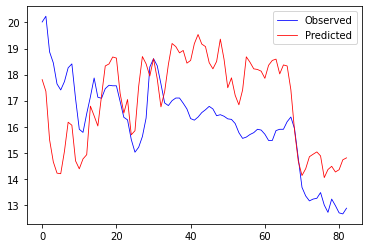

In [ ]:
### Quick Plot expected vs preducted
from matplotlib.pyplot import figure
print ("Predicted site:", site)
#test_yp = model.predict(test_x)
x_ax = range(len(test_y))
#plt.scatter(x_ax, ty, s=5, color="blue", label="Observed")
plt.plot(x_ax, test_y, lw=0.8, color="blue", label="Observed")
plt.plot(x_ax, test_yp, lw=0.8, color="red", label="Predicted")

plt.legend()
plt.show()

#### Evaluation R2, pearson R2

In [ ]:
import numpy as np

y = [1,2,3,4,5]
f = [1.9, 3.7, 5.8, 8.0, 9.6]
SSres = sum(map(lambda x: (x[0]-x[1])**2, zip(y, f)))
SStot = sum([(x-np.mean(y))**2 for x in y])
R2 = 1-(SSres/SStot)
print (SSres, SStot, R2)

# Import module
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X=np.array([1.9, 3.7, 5.8, 8.0, 9.6]).reshape(-1, 1)
#print (X)
y=[1,2,3,4,5]

model =  LinearRegression()
reg = model.fit(X, y)
# Predict the target variable
y_pred=reg.predict(X)
print (type(y), type(y_pred))
print ("dasd", y_pred)

# R-Square fitness
print('R-Square(metrics):', r2_score(y, y_pred))
# R-Square using score method
print('R-Sqaure(Score):',reg.score(X, y))

48.699999999999996 10.0 -3.869999999999999
<class 'list'> <class 'numpy.ndarray'>
dasd [1.02493573 1.93650386 3.         4.11413882 4.92442159]
R-Square(metrics): 0.9976606683804627
R-Sqaure(Score): 0.9976606683804627


### **Feature importance**

Classical for all variables

In [ ]:
from pandas import read_csv
# Read DATA.
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
#X = data.drop(['scenario', 'Tw'],axis=1) # For SB-31
X = data.drop(['id', 'site','Tr_hr', 'Tr_hl', 'NDVI','Tw'],axis=1) # For SB 59
y = data['Tw'] # data['Tw'] #
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (2407, 33) (2407,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (1684, 33) (723, 33) (1684,) (723,)


In [ ]:
from xgboost import XGBRegressor

### XGBoost model based on best parameters from mannual tuning
print ("computing ........")
model_m = XGBRegressor(
    alpha = 0.001,#0.1,
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,# 0.04544,
    max_depth = 8, #3,#3
    n_estimators = 1500,
    objective='reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5,
    gamma = 0.1,
    seed=1
    )


### Fit the model and evaluation using train ans test
eval_set = [(train_x, train_y), (test_x, test_y)]
model_m.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

### Prediction on train and test
pred_train = model_m.predict(train_x) # prediction for 'Train' values
predict_test = model_m.predict(test_x)

### RMSE and R2 on train and test using the model with best parameters
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE

print("Train","RMSE: %.4f" % (mean_squared_error(train_y, model_m.predict(train_x))**(1/2.0)))
print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, model_m.predict(test_x))**(1/2.0)))
print ()

print("Train","R2: %.4f" % (model_m.score(train_x, train_y))) # R2
print("Test", "R2: %.4f" % (model_m.score(test_x, test_y)))   # R2

computing ........
Train RMSE: 0.1135
Test RMSE: 0.2766

Train R2: 0.9972
Test R2: 0.9846


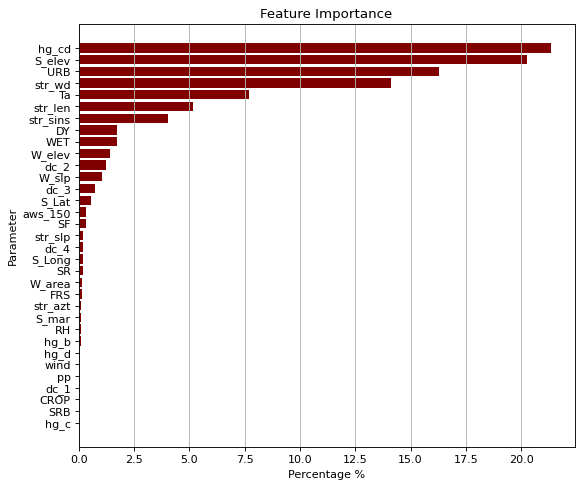

Importance in percentages: 
 [21.345263   20.252422   16.284113   14.117842    7.677388    5.157926
  4.051618    1.7560458   1.7141058   1.4326838   1.2563384   1.0518432
  0.7530701   0.55714154  0.34029272  0.32749692  0.22113603  0.19790062
  0.19001688  0.18639013  0.1682466   0.13757123  0.12424324  0.1227913
  0.11953074  0.11200381  0.06551355  0.06544343  0.05465483  0.04218015
  0.04088063  0.03876354  0.0371502 ]


In [ ]:
### Plot importance of parameters
import numpy as np
import matplotlib.pyplot as plt

f_importance = 100*model_m.feature_importances_
sorted_idx = np.argsort(f_importance)
fig = plt.figure(figsize=(8, 7), dpi=80)
plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(axis="x")
plt.xlabel("Percentage %")
plt.ylabel("Parameter")
plt.show()

print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values

#fig.savefig('002_sb59_xgb_feat_importance.png', dpi=1024)
#files.download("003_sb31_xgb_feat_importance.png")

### **RMSE and R for combinations of 1 variable**
For 33 variables, 33 combinations of 1 variable were set. For each combination, CV leave-one-out were performed


In [ ]:
### Claen variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
from pandas import read_csv
import itertools, copy, heapq

###### Read DATA.
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

###### Select predictors to get combination of sets
X = data.drop(['id', 'site','Tr_hr', 'Tr_hl', 'NDVI','Tw'],axis=1) #
#y = data['Tw'] # not used
print ("Shape of predictor variables to be combined:", X.shape)
names_pvars = X.columns.values # X has 33 variables
print ("Predictor variables to be combined ", len(names_pvars), ": \n",names_pvars)

# Get combination of variables
nc_vars = 1
c72 = list(itertools.combinations(names_pvars,nc_vars))
#print ("Combination with", len(c72))
print ("Combinations with",nc_vars," variable : \n", c72)

rmse_all_comb_tr, rmse_all_comb_ts = [], []
rp_all_comb_tr, rp_all_comb_ts = [], []
comb_names = []
#print (adasd)

#First varibale: 'Ta'
for i in range(33): # <---------------- SET the number of variables. Min: 1, Max: 33 variables
  print ("set of variables in testing ______ (",(i+1),")",c72[i][0])
  comb_names.append(c72[i][0])

  #print ("value of i:", i)
  df1 = data[['id',c72[i][0], 'Tw']] # Get data inlcuding ID, Predictors, and Response
  #df1 = data[['id','SF', 'Tw']] # To test an specific variable
  #print ("Variable included:", c72[i][0])
  #print ("Data base to be processed:",df1)

  ###### Once combinations were set, sites are removed one-by-one to make CV
  #! sites = [7] # To test only one variable out.
  sites = list(range(1,29+1)) # [7] #  <----------  May be SET

  f_imp_allsites = []
  rmse_tr, rmse_ts, rp_tr, rp_ts = [],[],[],[]

  for site in sites:
    print ("site:......",site)
    train = df1[df1.id != site] # Remove the row with id = 1
    test = df1[df1.id == site]  # Select the row with id = 1

    #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_x = train.drop(['id', 'Tw'], axis=1) # 'id' is not longer needed
    train_y = train['Tw']
    test_x = test.drop(['id','Tw'], axis=1) # 'id' is not longer needed
    test_y = test['Tw']
    #print ("dd:",train_y)

    #print("Site in test:",site," ...  Datasets dimension: \n train_x, train_y, test_x, test_y: \n",
    #        train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    ### model
    from xgboost import XGBRegressor
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error  ## use function MSE

    ### XGBoost model based on best parameters from mannual tuning
    #print ("computing ........")
    model_best_parm = XGBRegressor(
        alpha = 0.001,# alias "reg_alpha"
        booster = 'gbtree',
        colsample_bytree = 0.9,
        learning_rate = 0.01,
        max_depth = 8,
        n_estimators = 1500,
        objective = 'reg:squarederror',
        subsample = 1,#0.55,
        min_child_weight= 5, #1,
        gamma= 0.1, #0,
        seed=1
        )

    ### Fit the model and evaluation using train ans test
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

    ### Prediction on train and test
    pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
    pred_test = model_best_parm.predict(test_x)

    ### RMSE and R_Pearson on train and test using the model with best parameters
    #print("Train","RMSE: %.4f" % (mean_squared_error(train_y, pred_train)**(1/2.0)))
    print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, pred_test)**(1/2.0)))
    rmse_tr.append(mean_squared_error(train_y, pred_train)**(1/2.0))
    rmse_ts.append(mean_squared_error(test_y, pred_test)**(1/2.0))

    # calculate Pearson's correlation
    corr_train, _ = pearsonr(train_y, pred_train)
    corr_test, _ = pearsonr(test_y, pred_test)
    #print("Train","R_Pearson: %.4f" % corr_train)
    print("Test","R_Pearson: %.4f" % corr_test)
    rp_tr.append(corr_train)
    rp_ts.append(corr_test)
    print ()

  rmse_all_comb_tr.append(rmse_tr)
  rmse_all_comb_ts.append(rmse_ts)
  rp_all_comb_tr.append(rp_tr)
  rp_all_comb_ts.append(rp_ts)


Shape of predictor variables to be combined: (2407, 33)
Predictor variables to be combined  33 : 
 ['Ta' 'SR' 'DY' 'pp' 'RH' 'wind' 'SF' 'W_area' 'W_elev' 'W_slp' 'str_len'
 'str_slp' 'str_azt' 'str_wd' 'str_sins' 'FRS' 'URB' 'WET' 'CROP' 'SRB'
 'S_Lat' 'S_Long' 'S_elev' 'S_mar' 'hg_c' 'hg_d' 'hg_b' 'hg_cd' 'dc_1'
 'dc_2' 'dc_3' 'dc_4' 'aws_150']
Combinations with 1  variable : 
 [('Ta',), ('SR',), ('DY',), ('pp',), ('RH',), ('wind',), ('SF',), ('W_area',), ('W_elev',), ('W_slp',), ('str_len',), ('str_slp',), ('str_azt',), ('str_wd',), ('str_sins',), ('FRS',), ('URB',), ('WET',), ('CROP',), ('SRB',), ('S_Lat',), ('S_Long',), ('S_elev',), ('S_mar',), ('hg_c',), ('hg_d',), ('hg_b',), ('hg_cd',), ('dc_1',), ('dc_2',), ('dc_3',), ('dc_4',), ('aws_150',)]
set of variables in testing ______ ( 1 ) Ta
value of i: 0
site:...... 1
Test RMSE: 1.6281
Test R_Pearson: 0.7605

site:...... 2
Test RMSE: 1.3214
Test R_Pearson: 0.8269

site:...... 3
Test RMSE: 1.5832
Test R_Pearson: 0.7652

site:...... 4

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.3655
Test R_Pearson: -0.4756

site:...... 9
Test RMSE: 1.9068
Test R_Pearson: 0.0720

site:...... 10
Test RMSE: 2.6235
Test R_Pearson: -0.5971

site:...... 11
Test RMSE: 1.7805
Test R_Pearson: 0.3267

site:...... 12
Test RMSE: 2.6871
Test R_Pearson: -0.0258

site:...... 13
Test RMSE: 2.4438
Test R_Pearson: -0.1662

site:...... 14
Test RMSE: 2.2398
Test R_Pearson: -0.0863

site:...... 15
Test RMSE: 1.7688
Test R_Pearson: 0.1135

site:...... 16
Test RMSE: 1.5709
Test R_Pearson: 0.3944

site:...... 17
Test RMSE: 2.3128
Test R_Pearson: -0.4806

site:...... 18
Test RMSE: 1.5794
Test R_Pearson: 0.4405

site:...... 19
Test RMSE: 2.1554
Test R_Pearson: -0.3553

site:...... 20
Test RMSE: 2.0202
Test R_Pearson: -0.1783

site:...... 21
Test RMSE: 1.9817
Test R_Pearson: 0.2663

site:...... 22
Test RMSE: 2.6615
Test R_Pearson: -0.2436

site:...... 23
Test RMSE: 2.6856
Test R_Pearson: -0.4712

site:...... 24
Test RMSE: 2.1738
Test R_Pearson: -0.2210

site:...... 25
Test RMSE: 3.3094
Tes

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7551
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7622
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1522
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7850
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9603
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0280
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7937
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6274
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9104
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7253
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9021
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8827
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4590
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7381
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6595
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4079
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.8732
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4750
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2935
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9484
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9349
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0606
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8275
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7324
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.6378
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2408
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7176
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6482
Test R_Pearson: nan

set of variables in testing ______ ( 9 ) W_elev
value of i: 8
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7579
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7549
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7692
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7726
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7848
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7500
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.6244
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7774
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6803
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.4074
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2379
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7288
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7691
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0611
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6900
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6287
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7181
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7237
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7578
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4352
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7832
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0707
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3347
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8190
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4750
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3441
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.2943
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7065
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8184
Test R_Pearson: nan

set of variables in testing ______ ( 10 ) W_slp
value of i: 9
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7660
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6371
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7644
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1704
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.9407
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9606
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8991
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7477
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.3643
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5045
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.9008
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7081
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7498
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1420
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7780
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0995
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4132
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7217
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5263
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5005
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1680
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0552
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8192
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8042
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6101
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6121
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3020
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6798
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0941
Test R_Pearson: nan

set of variables in testing ______ ( 11 ) str_len
value of i: 10
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7557
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7354
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8573
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8443
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7007
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9023
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2413
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6279
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6213
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0617
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7010
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8239
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1382
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6994
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6244
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4077
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7510
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0153
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4305
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8363
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8258
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8181
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8279
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4806
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.4794
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3154
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7049
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3053
Test R_Pearson: nan

set of variables in testing ______ ( 12 ) str_slp
value of i: 11
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.1651
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7566
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7730
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0140
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.4992
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9413
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9169
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5511
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.0232
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.1840
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.1417
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2369
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7516
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4526
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6791
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0166
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7116
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9768
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7204
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3693
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7500
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7720
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9559
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0753
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4499
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.8487
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.2940
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7057
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6369
Test R_Pearson: nan

set of variables in testing ______ ( 13 ) str_azt
value of i: 12
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7698
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8480
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2719
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8222
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8751
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.7104
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7866
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8469
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4212
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.8752
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7679
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.8476
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.6354
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1775
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7774
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9092
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5508
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7233
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3466
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4495
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5076
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1114
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6736
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9065
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.7518
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.5762
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5074
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4598
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6811
Test R_Pearson: nan

set of variables in testing ______ ( 14 ) str_wd
value of i: 13
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7281
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8175
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7625
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7766
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7931
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7491
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9638
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7740
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6276
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5317
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7256
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8888
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7284
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.0035
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7251
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7223
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4079
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8369
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7186
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0009
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8804
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9633
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8382
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8197
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6136
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9273
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.8460
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7169
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6791
Test R_Pearson: nan

set of variables in testing ______ ( 15 ) str_sins
value of i: 14
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7658
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7690
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7485
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8170
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8723
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7311
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8678
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7711
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7202
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.2572
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7221
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6856
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7674
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7627
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7060
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6440
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6773
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7270
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2304
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4808
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7620
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8535
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0466
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8731
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6024
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3389
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0285
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6802
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.2519
Test R_Pearson: nan

set of variables in testing ______ ( 16 ) FRS
value of i: 15
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7149
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7552
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7621
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1718
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7851
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1208
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0332
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7944
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2533
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9587
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7248
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7153
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7450
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8316
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7328
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7141
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4085
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8236
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4754
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2958
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7490
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7728
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0649
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2015
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7436
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3375
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2173
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7176
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6796
Test R_Pearson: nan

set of variables in testing ______ ( 17 ) URB
value of i: 16
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7552
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7636
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8653
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1055
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8927
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9006
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0590
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7423
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6325
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0557
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7044
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8617
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6655
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6646
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6245
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5152
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7272
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5683
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2821
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7579
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9451
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8181
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8040
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.6200
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9260
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7800
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7106
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3287
Test R_Pearson: nan

set of variables in testing ______ ( 18 ) WET
value of i: 17
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7553
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7617
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8677
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7851
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1392
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9756
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5528
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6928
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6317
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7728
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7318
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8612
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8935
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6653
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8998
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.0008
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8147
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6411
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3463
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7478
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7652
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8182
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8110
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6408
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3380
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3018
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7113
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6003
Test R_Pearson: nan

set of variables in testing ______ ( 19 ) CROP
value of i: 18
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7152
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7559
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7614
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8660
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0584
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7006
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0293
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6269
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9696
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3398
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8181
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7323
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8599
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8109
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7022
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6245
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7382
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8276
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5139
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4131
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8341
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8118
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0829
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8287
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5183
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1547
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5109
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7112
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0386
Test R_Pearson: nan

set of variables in testing ______ ( 20 ) SRB
value of i: 19
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7150
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.7800
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7624
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7783
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.7896
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7569
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9011
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7955
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6277
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9128
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7282
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7096
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8230
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0452
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7391
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7573
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0414
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.8699
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4717
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2949
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8354
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7764
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9543
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8277
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7250
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.6353
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2449
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7173
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6458
Test R_Pearson: nan

set of variables in testing ______ ( 21 ) S_Lat
value of i: 20
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7170
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7570
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7354
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1688
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0310
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7005
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0584
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.9055
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1550
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6202
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7699
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6836
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7261
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8425
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9252
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8948
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7084
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7233
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6573
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4963
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1564
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9657
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8177
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0550
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0124
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4714
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.2934
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6792
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6002
Test R_Pearson: nan

set of variables in testing ______ ( 22 ) S_Long
value of i: 21
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7214
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7770
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3233
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 5.3289
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7851
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7174
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7805
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8940
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8035
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6407
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0473
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6847
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9449
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6717
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9911
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5714
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6175
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3152
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1146
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4570
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.1307
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.3221
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2169
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3667
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.9693
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7590
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.1651
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.2311
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9529
Test R_Pearson: nan

set of variables in testing ______ ( 23 ) S_elev
value of i: 22
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7586
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7569
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7694
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0352
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0439
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9653
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0403
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9304
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9717
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9337
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7283
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6861
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7616
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0036
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9375
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6275
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0439
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9735
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4714
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7868
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7580
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7654
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0840
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8103
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7241
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.3437
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.2949
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9960
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6022
Test R_Pearson: nan

set of variables in testing ______ ( 24 ) S_mar
value of i: 23
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5559
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7815
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1559
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 5.3323
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7850
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7010
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7803
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8935
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8039
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6417
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0458
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8839
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7616
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6715
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6701
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2273
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6169
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7375
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1378
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7782
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7478
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9197
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1991
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1804
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0907
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7112
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9837
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8596
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4445
Test R_Pearson: nan

set of variables in testing ______ ( 25 ) hg_c
value of i: 24
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7552
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7624
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3678
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7850
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9520
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8932
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7813
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2565
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9770
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7530
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8866
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8252
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1506
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9360
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6245
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4602
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8510
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3840
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.3384
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8346
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9136
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8181
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0591
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6343
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.6349
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.1467
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7108
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6030
Test R_Pearson: nan

set of variables in testing ______ ( 26 ) hg_d
value of i: 25
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7159
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7553
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7633
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0369
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7852
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7260
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7726
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7581
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2799
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.1942
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0186
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7084
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7446
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6981
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9339
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6240
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7233
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6477
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6885
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4550
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7957
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7830
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8188
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2334
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4450
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8895
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2344
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7113
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4514
Test R_Pearson: nan

set of variables in testing ______ ( 27 ) hg_b
value of i: 26
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.9843
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7553
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7724
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8377
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7885
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8125
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8263
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 4.1039
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7583
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.5501
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8374
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7083
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7443
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.8029
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7006
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7150
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4513
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1988
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7296
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5600
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7492
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7700
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8234
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8206
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.8708
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5604
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.9423
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7071
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6195
Test R_Pearson: nan

set of variables in testing ______ ( 28 ) hg_cd
value of i: 27
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7150
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7555
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7617
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8667
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7854
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7006
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3797
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7347
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1124
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.1988
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9948
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7323
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8268
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8247
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8079
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6240
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0195
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7250
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6678
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4286
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8338
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8862
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8365
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8252
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4462
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8862
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2233
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7112
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6343
Test R_Pearson: nan

set of variables in testing ______ ( 29 ) dc_1
value of i: 28
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7149
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7553
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7686
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7776
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7852
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9511
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0240
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9440
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1602
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6177
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9141
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7314
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8596
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0457
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7342
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7127
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6338
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9542
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5380
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4868
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7454
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0619
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9121
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0594
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9677
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1900
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.6003
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7109
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3850
Test R_Pearson: nan

set of variables in testing ______ ( 30 ) dc_2
value of i: 29
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7554
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7687
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7793
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7853
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7204
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0325
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9304
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2800
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.1651
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1941
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7305
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8590
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6969
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7105
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6240
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7038
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9718
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8552
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3480
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7971
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7841
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0881
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8288
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4590
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7245
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0538
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7107
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2010
Test R_Pearson: nan

set of variables in testing ______ ( 31 ) dc_3
value of i: 30
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7148
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7552
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7623
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8410
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7850
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7214
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7759
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7347
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7470
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9553
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0341
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7146
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7446
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1190
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6746
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7141
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4604
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.8651
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6021
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.3350
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7521
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7693
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8239
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0749
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7226
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.6763
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 5.0209
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7174
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6135
Test R_Pearson: nan

set of variables in testing ______ ( 32 ) dc_4
value of i: 31
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7151
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5514
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7687
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1698
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5649
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9912
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.3794
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7332
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2678
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.5419
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7445
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7127
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8173
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8391
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.0323
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6309
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6096
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9700
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9950
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.2683
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8412
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7665
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0623
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8190
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6545
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.4895
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.8905
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.2389
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.1947
Test R_Pearson: nan

set of variables in testing ______ ( 33 ) aws_150
value of i: 32
site:...... 1


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7321
Test R_Pearson: nan

site:...... 2


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7553
Test R_Pearson: nan

site:...... 3


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7629
Test R_Pearson: nan

site:...... 4


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8391
Test R_Pearson: nan

site:...... 5


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7852
Test R_Pearson: nan

site:...... 6


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8109
Test R_Pearson: nan

site:...... 7


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7795
Test R_Pearson: nan

site:...... 8


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7755
Test R_Pearson: nan

site:...... 9


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.9576
Test R_Pearson: nan

site:...... 10


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.6202
Test R_Pearson: nan

site:...... 11


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.0448
Test R_Pearson: nan

site:...... 12


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7081
Test R_Pearson: nan

site:...... 13


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7459
Test R_Pearson: nan

site:...... 14


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.6377
Test R_Pearson: nan

site:...... 15


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.2822
Test R_Pearson: nan

site:...... 16


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7143
Test R_Pearson: nan

site:...... 17


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.4070
Test R_Pearson: nan

site:...... 18


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7289
Test R_Pearson: nan

site:...... 19


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 2.7125
Test R_Pearson: nan

site:...... 20


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7848
Test R_Pearson: nan

site:...... 21


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7483
Test R_Pearson: nan

site:...... 22


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7735
Test R_Pearson: nan

site:...... 23


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8372
Test R_Pearson: nan

site:...... 24


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.8247
Test R_Pearson: nan

site:...... 25


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.1996
Test R_Pearson: nan

site:...... 26


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5085
Test R_Pearson: nan

site:...... 27


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5021
Test R_Pearson: nan

site:...... 28


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 1.7098
Test R_Pearson: nan

site:...... 29


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Test RMSE: 3.5917
Test R_Pearson: nan



/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
# Save all RMSE of all combinations (33 combinatios - one for each variable)
df = pd.DataFrame(rmse_all_comb_ts)
df.to_csv('rmse.csv', encoding = 'utf-8-sig')

df = pd.DataFrame(rp_all_comb_ts)
df.to_csv('r_pearson.csv', encoding = 'utf-8-sig')

### **RMSE and R for combinations of 2 and more variable keeping Ta as first variable**
For 33 variables, 32 were employed to get combinations. Here, for example some combinations: (Ta,DY), (Ta,SR), (Ta, pp), ...

In [ ]:
### Claen variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
from pandas import read_csv
import itertools, copy, heapq

###### Read DATA.
# From: D:\research\ML_model\new_data\050_spatial_data_no_normal_29sites.csv
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

###### Select predictors to get combination of sets
# 'Ta' is removed from the set of combinations because it will be considered always
X = data.drop(['id', 'site','Tr_hr', 'Tr_hl', 'NDVI','Tw'],axis=1)

root = ['Ta','RH','hg_cd','W_elev','aws_150']  #   <---- SET here what variables to keep as pivot
v_2comb = [ele for ele in X if ele not in root]
print (v_2comb)

children = []
for i in v_2comb:
    n_item = []
    n_item.append(root)
    n_item.append([i])
    n_item = list(itertools.chain(*n_item))
    #print (len(n_item), n_item)
    children.append(n_item)

print ("Combinations of ",3," variable: ",len(children))
print ("cccc", children)

rmse_all_comb_tr, rmse_all_comb_ts = [], []
rp_all_comb_tr, rp_all_comb_ts = [], []
comb_names = []

# Loop through all the combinations
#for i in range(len(children)):
for i in range(len(children)):
  print ("dsadasd", children[i])
  print ("set of variables in testing ______ (",(i+1),")",children[i])
  comb_names.append(children[i])

  vars_each =[['id']]
  #aux1 = [vars_ech.children[i]) for k in range(nc_vars+1)]  # Get vars_ech: ['id', 'Ta', 'SR', 'Tw']
  vars_each.append(children[i])
  vars_each.append(['Tw'])
  vars_each = list(itertools.chain(*vars_each))
  print ("Variables for this combination:", vars_each)

  df1 = data[vars_each] # Get data inlcuding ID, Predictors, and Response
  print ("Data for this combination:",df1)

  ###### Once combinations were set, sites are removed one-by-one to make CV
  sites = list(range(1,29+1)) # [10] #


  rmse_tr, rmse_ts, rp_tr, rp_ts = [],[],[],[]

  for site in sites:
    print ("site:......",site, "  Child",children[i])
    train = df1[df1.id != site] # Remove the row with id = 1
    test = df1[df1.id == site]  # Select the row with id = 1

    #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_x = train.drop(['id', 'Tw'], axis=1) # 'id' is not longer needed
    train_y = train['Tw']
    test_x = test.drop(['id','Tw'], axis=1) # 'id' is not longer needed
    test_y = test['Tw']
    #print ("dd:",train_y)
    #print (adasda)

    #print("Site in test:",site," ...  Datasets dimension: \n train_x, train_y, test_x, test_y: \n",
    #        train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    ### model
    from xgboost import XGBRegressor
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error  ## use function MSE

    ### XGBoost model based on best parameters from mannual tuning
    #print ("computing ........")
    model_best_parm = XGBRegressor(
        alpha = 0.001,# alias "reg_alpha"
        booster = 'gbtree',
        colsample_bytree = 0.9,
        learning_rate = 0.01,
        max_depth = 8,
        n_estimators = 1500,
        objective = 'reg:squarederror',
        subsample = 1,#0.55,
        min_child_weight= 5, #1,
        gamma= 0.1, #0,
        seed=1
        )

    ### Fit the model and evaluation using train ans test
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

    ### Prediction on train and test
    pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
    pred_test = model_best_parm.predict(test_x)

    ### RMSE and R_Pearson on train and test using the model with best parameters
    #print("Train","RMSE: %.4f" % (mean_squared_error(train_y, pred_train)**(1/2.0)))
    print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, pred_test)**(1/2.0)))
    rmse_tr.append(mean_squared_error(train_y, pred_train)**(1/2.0))
    rmse_ts.append(mean_squared_error(test_y, pred_test)**(1/2.0))

    # calculate Pearson's correlation
    corr_train, _ = pearsonr(train_y, pred_train)
    corr_test, _ = pearsonr(test_y, pred_test)
    #print("Train","R_Pearson: %.4f" % corr_train)
    print("Test","R_Pearson: %.4f" % corr_test)
    rp_tr.append(corr_train)
    rp_ts.append(corr_test)
    print ()

  rmse_all_comb_tr.append(rmse_tr)
  rmse_all_comb_ts.append(rmse_ts)
  rp_all_comb_tr.append(rp_tr)
  rp_all_comb_ts.append(rp_ts)

print ("Done....")

['SR', 'DY', 'pp', 'wind', 'SF', 'W_area', 'W_slp', 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'S_Lat', 'S_Long', 'S_elev', 'S_mar', 'hg_c', 'hg_d', 'hg_b', 'dc_1', 'dc_2', 'dc_3', 'dc_4']
Combinations of  3  variable:  28
cccc [['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'SR'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'DY'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'pp'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'wind'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'SF'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'W_area'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'W_slp'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'str_len'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'str_slp'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'str_azt'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'str_wd'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'str_sins'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_150', 'FRS'], ['Ta', 'RH', 'hg_cd', 'W_elev', 'aws_1

In [ ]:
# For names print 'comb_names'
rmse_all_comb_ts

In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
# Save all RMSE of all combinations (33 combinatios - one for each variable)
df = pd.DataFrame(rmse_all_comb_ts)
df.to_csv('rmse.csv', encoding = 'utf-8-sig')

df = pd.DataFrame(rp_all_comb_ts)
df.to_csv('r_pearson.csv', encoding = 'utf-8-sig')

In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
# Save all RMSE of all combinations (33 combinatios - one for each variable)
df = pd.DataFrame(rmse_all_comb_tr)
df.to_csv('rmse_tr.csv', encoding = 'utf-8-sig')

df = pd.DataFrame(rp_all_comb_tr)
df.to_csv('r_pearson_tr.csv', encoding = 'utf-8-sig')

In [ ]:
# Save all combination names
df = pd.DataFrame(comb_names)
df.to_csv('comb_names.csv', encoding = 'utf-8-sig')

### **Feature importance**
29 sets of sites are tested, each set has one site out. For example in the first set site-1 is out and the 28 left are tested.

In [ ]:
### Claen variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
### Select columns. Total of columns = 39
# General    2V: 'id', 'site'
# Weather    7V: 'Ta', 'SR', 'DY', 'pp', 'RH', 'wind', 'SF'
# Watershed  3V: 'W_area', 'W_elev', 'W_slp'
# Stream     5V: 'str_len', 'str_slp', 'str_azt', 'str_wd', 'str_sins'
# LandCover  8V: 'FRS', 'URB', 'WET', 'CROP', 'SRB', 'Tr_hr', 'Tr_hl', 'NDVI'
# Site       4V: 'S_Lat', 'S_Long', 'S_elev', 'S_mar'
# Soil       4V: 'hg_c', 'hg_d', 'hg_b', 'hg_cd'
# Drainage   5V: 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'aws_150'
# Response   1V: 'Tw'

In [ ]:
lst = list(range(1,29+1))
lst

In [ ]:
from pandas import read_csv
### Read DATA.
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
df = data.drop(['site','Tr_hr', 'Tr_hl', 'NDVI'],axis=1) # For SB-31
df = df.drop(['S_Long', 'S_mar', 'SRB'],axis=1) # For SB-31
df = df.drop(['RH', 'wind', 'pp'],axis=1) # For SB-31
df = df.drop(['dc_1','hg_d'],axis=1) # For SB-31

### Split into train and test (Random split)
site = 14
sites = list(range(1,29+1)) # [14] #

f_imp_allsites = []
for site in sites:
  print ("site:......",site)
  train = df[df.id != site] # Remove the row with id = 1
  test = df[df.id == site]  # Select the row with id = 1

  #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
  train_x = train.drop(['id', 'Tw'], axis=1) # 'id' is not longer needed
  train_y = train['Tw']
  test_x = test.drop(['id','Tw'], axis=1) # 'id' is not longer needed
  test_y = test['Tw']

  print("Site in test:",site," ...  Datasets dimension: \n train_x, train_y, test_x, test_y: \n",
        train_x.shape, test_x.shape, train_y.shape, test_y.shape)

  ##### Modeling
  from xgboost import XGBRegressor

  ### XGBoost model based on best parameters from mannual tuning
  print ("computing ........")
  model_best_parm = XGBRegressor(
      alpha = 0.001,# alias "reg_alpha"
      booster = 'gbtree',
      colsample_bytree = 0.9,
      learning_rate = 0.01,
      max_depth = 8,
      n_estimators = 1500,
      objective = 'reg:squarederror',
      subsample = 1,#0.55,
      min_child_weight= 5, #1,
      gamma= 0.1, #0,
      seed=1
      )

  ### Fit the model and evaluation using train ans test
  eval_set = [(train_x, train_y), (test_x, test_y)]
  model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

  ### Prediction on train and test
  pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
  predict_test = model_best_parm.predict(test_x)

  ### RMSE and R2 on train and test using the model with best parameters
  from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE

  print("Train","RMSE: %.4f" % (mean_squared_error(train_y, model_best_parm.predict(train_x))**(1/2.0)))
  print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, model_best_parm.predict(test_x))**(1/2.0)))
  #print ()

  print("Train","R2: %.4f" % (model_best_parm.score(train_x, train_y))) # R2
  print("Test", "R2: %.4f" % (model_best_parm.score(test_x, test_y)))   # R2


  ###### Feature importance
  print ("Importance of variables in proportion")
  f_imp_100 = 100*model_best_parm.feature_importances_
  print ("Variables ",len(f_imp_100),":    ", train_x.columns)
  print ("Values:", f_imp_100)
  #print (",".join(["{:.3f}".format(item) for item in f_imp_100]))

  #dict_fi = dict(zip(train_x.columns, f_imp_100)) # Build a dictionary with variables and feature-importance
  #dict_fi_sorted = sorted(dict_fi.items(), key=lambda x: x[1], reverse=True) # Sort the dictionary by feature-importance values
  #print (dict_fi_sorted)
  #print (dict_fi_sorted[0][0], dict_fi_sorted[0][1])
  f_imp_allsites.append(f_imp_100)
  print ()



site:...... 1
Site in test: 1  ...  Datasets dimension: 
 train_x, train_y, test_x, test_y: 
 (2324, 25) (83, 25) (2324,) (83,)
computing ........
Train RMSE: 0.1209
Test RMSE: 0.2018
Train R2: 0.9969
Test R2: 0.9861
Importance of variables in proportion
Variables  25 :     Index(['Ta', 'SR', 'DY', 'SF', 'W_area', 'W_elev', 'W_slp', 'str_len',
       'str_slp', 'str_azt', 'str_wd', 'str_sins', 'FRS', 'URB', 'WET', 'CROP',
       'S_Lat', 'S_elev', 'hg_c', 'hg_b', 'hg_cd', 'dc_2', 'dc_3', 'dc_4',
       'aws_150'],
      dtype='object')
Values: [ 6.457574    0.15120073  1.2433891   0.22220135  0.17513797  1.3042079
  0.6319004   6.238638    0.26801828  0.16076173 14.857233    2.0528665
  0.14013459  5.7632813   0.48427764  0.07829657  0.06690195 20.22369
  0.06376708  0.2803473  29.624313    8.613591    0.11293802  0.12569803
  0.65962887]

site:...... 2
Site in test: 2  ...  Datasets dimension: 
 train_x, train_y, test_x, test_y: 
 (2324, 25) (83, 25) (2324,) (83,)
computing ........
T

In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
df = pd.DataFrame(f_imp_allsites)
df.to_csv('feat_import.csv', encoding = 'utf-8-sig')

In [ ]:
### Plot importance of parameters
import numpy as np
import matplotlib.pyplot as plt

f_importance = 100*model_best_parm.feature_importances_
sorted_idx = np.argsort(f_importance)
fig = plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(axis="x")
plt.xlabel("Percentage %")
plt.ylabel("Parameter")
plt.show()

print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values

#fig.savefig('002_sb31_xgb_feat_importance.png', dpi=1024)
#files.download("003_sb31_xgb_feat_importance.png")

# of epochs: 1500


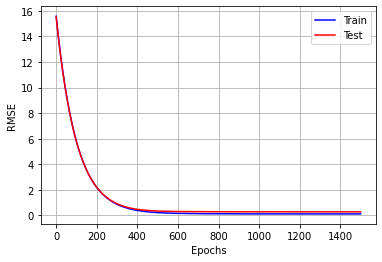

In [ ]:
### Plot learning rate
import matplotlib.pyplot as plt
results = model_best_parm.evals_result() # Get rmse for validation 0 (train) & validatio 1 (test)

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
print ("# of epochs:", epochs)

fig = plt.figure(figsize=(6, 4))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train', color='blue')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid()
plt.show() #'''

from google.colab import files
#fig.savefig('001_sb31_xgb_learning_curve.png', dpi=1024)
#files.download("001_sb31_xgb_learning_curve.png")

### **Search the best path and its scores**

In [ ]:
from pandas import read_csv
import itertools, copy, heapq

###### Read DATA.
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

###### Select predictors to get combination of sets
# 'Ta' is removed from the set of combinations because it will be considered always
X = data.drop(['id', 'site','Tr_hr', 'Tr_hl', 'NDVI','Tw'],axis=1)

# Good route
#root = ['Ta', 'SR','hg_cd','W_elev','aws_150','DY','dc_2','S_Long','str_sins','str_wd','S_Lat','S_mar',
#        'hg_d','wind', 'pp','RH','FRS', 'SRB','W_area','SF','hg_c','str_slp','dc_1','CROP',
#        'URB','dc_3','hg_b','str_azt','dc_4','S_elev','str_len','WET']  #   <---- SET here what variables to keep as pivot
# Worst route
root = ['Ta', 'str_azt','pp','SF','hg_c', 'SRB','dc_1','URB','str_sins','S_mar','W_area','S_Long',
        'aws_150','CROP','hg_d','str_len','W_slp','dc_2','FRS','S_Lat','hg_b','WET','dc_3','dc_4',
        'str_wd', 'str_slp','S_elev','hg_cd','W_elev','wind','SR','RH']  #   <---- SET here what variables to keep as pivot

v_2comb = [ele for ele in X if ele not in root]
print (v_2comb)

children = []
for i in v_2comb:
    n_item = []
    n_item.append(root)
    n_item.append([i])
    n_item = list(itertools.chain(*n_item))
    #print (len(n_item), n_item)
    children.append(n_item)

print ("Combinations of variable: ",len(children))
print ("cccc", children)

rmse_all_comb_tr, rmse_all_comb_ts = [], []
rp_all_comb_tr, rp_all_comb_ts = [], []
comb_names = []

# Loop through all the combinations
#for i in range(len(children)):
for i in range(len(children)):
  print ("dsadasd", children[i])
  print ("set of variables in testing ______ (",(i+1),")",children[i])
  comb_names.append(children[i])

  vars_each =[['id']]
  #aux1 = [vars_ech.children[i]) for k in range(nc_vars+1)]  # Get vars_ech: ['id', 'Ta', 'SR', 'Tw']
  vars_each.append(children[i])
  vars_each.append(['Tw'])
  vars_each = list(itertools.chain(*vars_each))
  print ("Variables for this combination:", vars_each)

  df1 = data[vars_each] # Get data inlcuding ID, Predictors, and Response
  #print ("Data for this combination:",df1)

  ###### Once combinations were set, sites are removed one-by-one to make CV
  sites = list(range(1,29+1)) # [10] #


  rmse_tr, rmse_ts, rp_tr, rp_ts = [],[],[],[]

  for site in sites:
    print ("site:......",site, "  Child",children[i])
    train = df1[df1.id != site] # Remove the row with id = 1
    test = df1[df1.id == site]  # Select the row with id = 1

    #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_x = train.drop(['id', 'Tw'], axis=1) # 'id' is not longer needed
    train_y = train['Tw']
    test_x = test.drop(['id','Tw'], axis=1) # 'id' is not longer needed
    test_y = test['Tw']
    #print ("dd:",train_y)
    #print (adasda)

    #print("Site in test:",site," ...  Datasets dimension: \n train_x, train_y, test_x, test_y: \n",
    #        train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    ### model
    from xgboost import XGBRegressor
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error  ## use function MSE

    ### XGBoost model based on best parameters from mannual tuning
    #print ("computing ........")
    model_best_parm = XGBRegressor(
        alpha = 0.001,# alias "reg_alpha"
        booster = 'gbtree',
        colsample_bytree = 0.9,
        learning_rate = 0.01,
        max_depth = 8,
        n_estimators = 1500,
        objective = 'reg:squarederror',
        subsample = 1,#0.55,
        min_child_weight= 5, #1,
        gamma= 0.1, #0,
        seed=1
        )

    ### Fit the model and evaluation using train ans test
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

    ### Prediction on train and test
    pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
    pred_test = model_best_parm.predict(test_x)

    ### RMSE and R_Pearson on train and test using the model with best parameters
    #print("Train","RMSE: %.4f" % (mean_squared_error(train_y, pred_train)**(1/2.0)))
    print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, pred_test)**(1/2.0)))
    rmse_tr.append(mean_squared_error(train_y, pred_train)**(1/2.0))
    rmse_ts.append(mean_squared_error(test_y, pred_test)**(1/2.0))

    # calculate Pearson's correlation
    corr_train, _ = pearsonr(train_y, pred_train)
    corr_test, _ = pearsonr(test_y, pred_test)
    #print("Train","R_Pearson: %.4f" % corr_train)
    print("Test","R_Pearson: %.4f" % corr_test)
    rp_tr.append(corr_train)
    rp_ts.append(corr_test)
    print ()

  rmse_all_comb_tr.append(rmse_tr)
  rmse_all_comb_ts.append(rmse_ts)
  rp_all_comb_tr.append(rp_tr)
  rp_all_comb_ts.append(rp_ts)

print (rmse_all_comb_ts)
print (rp_all_comb_ts)

print ("Done....")

['SR', 'DY', 'RH', 'wind', 'W_elev', 'str_slp', 'str_wd', 'S_elev', 'hg_cd']
Combinations of variable:  9
cccc [['Ta', 'str_azt', 'pp', 'SF', 'hg_c', 'SRB', 'dc_1', 'URB', 'str_sins', 'S_mar', 'W_area', 'S_Long', 'aws_150', 'CROP', 'hg_d', 'str_len', 'W_slp', 'dc_2', 'FRS', 'S_Lat', 'hg_b', 'WET', 'dc_3', 'dc_4', 'SR'], ['Ta', 'str_azt', 'pp', 'SF', 'hg_c', 'SRB', 'dc_1', 'URB', 'str_sins', 'S_mar', 'W_area', 'S_Long', 'aws_150', 'CROP', 'hg_d', 'str_len', 'W_slp', 'dc_2', 'FRS', 'S_Lat', 'hg_b', 'WET', 'dc_3', 'dc_4', 'DY'], ['Ta', 'str_azt', 'pp', 'SF', 'hg_c', 'SRB', 'dc_1', 'URB', 'str_sins', 'S_mar', 'W_area', 'S_Long', 'aws_150', 'CROP', 'hg_d', 'str_len', 'W_slp', 'dc_2', 'FRS', 'S_Lat', 'hg_b', 'WET', 'dc_3', 'dc_4', 'RH'], ['Ta', 'str_azt', 'pp', 'SF', 'hg_c', 'SRB', 'dc_1', 'URB', 'str_sins', 'S_mar', 'W_area', 'S_Long', 'aws_150', 'CROP', 'hg_d', 'str_len', 'W_slp', 'dc_2', 'FRS', 'S_Lat', 'hg_b', 'WET', 'dc_3', 'dc_4', 'wind'], ['Ta', 'str_azt', 'pp', 'SF', 'hg_c', 'SRB', '

In [ ]:
print (comb_names)

[['Ta', 'SR', 'hg_cd', 'W_elev', 'aws_150', 'DY', 'dc_2', 'S_Long', 'str_sins', 'str_wd', 'S_Lat', 'S_mar', 'hg_d', 'wind', 'pp', 'RH', 'FRS', 'SRB', 'W_area', 'SF', 'hg_c', 'str_slp', 'dc_1', 'CROP', 'URB', 'dc_3', 'hg_b', 'str_azt', 'dc_4', 'S_elev', 'str_len', 'WET', 'W_slp']]


In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
# Save all RMSE of all combinations (33 combinatios - one for each variable)
df = pd.DataFrame(rmse_all_comb_ts)
df.to_csv('rmse.csv', encoding = 'utf-8-sig')

df = pd.DataFrame(rp_all_comb_ts)
df.to_csv('r_pearson.csv', encoding = 'utf-8-sig')

In [ ]:
# Save all combination names
df = pd.DataFrame(comb_names)
df.to_csv('comb_names.csv', encoding = 'utf-8-sig')

In [ ]:
from pandas import read_csv
import itertools, copy, heapq

###### Read DATA.
data = read_csv('050_spatial_data_no_normal_29sites.csv', header=0, index_col=0)
#print (data.head())

###### Select predictors to get combination of sets
# 'Ta' is removed from the set of combinations because it will be considered always
X = data.drop(['id', 'site','Tr_hr', 'Tr_hl', 'NDVI','Tw'],axis=1)

root = ['Ta', 'SR','hg_cd','W_elev','aws_150','DY','dc_2','S_Long','str_sins','str_wd','S_Lat','S_mar',
        'hg_d','wind', 'pp','RH','FRS', 'SRB','W_area','SF','hg_c','str_slp','dc_1']  #   <---- SET here what variables to keep as pivot
v_2comb = [ele for ele in X if ele not in root]
print (v_2comb)

children = []
for i in v_2comb:
    n_item = []
    n_item.append(root)
    n_item.append([i])
    n_item = list(itertools.chain(*n_item))
    #print (len(n_item), n_item)
    children.append(n_item)

print ("Combinations of ",3," variable: ",len(children))
print ("cccc", children)

rmse_all_comb_tr, rmse_all_comb_ts = [], []
rp_all_comb_tr, rp_all_comb_ts = [], []
comb_names = []

# Loop through all the combinations
#for i in range(len(children)):
for i in range(len(children)):
  print ("dsadasd", children[i])
  print ("set of variables in testing ______ (",(i+1),")",children[i])
  comb_names.append(children[i])

  vars_each =[['id']]
  #aux1 = [vars_ech.children[i]) for k in range(nc_vars+1)]  # Get vars_ech: ['id', 'Ta', 'SR', 'Tw']
  vars_each.append(children[i])
  vars_each.append(['Tw'])
  vars_each = list(itertools.chain(*vars_each))
  print ("Variables for this combination:", vars_each)

  df1 = data[vars_each] # Get data inlcuding ID, Predictors, and Response
  #print ("Data for this combination:",df1)

  ###### Once combinations were set, sites are removed one-by-one to make CV
  sites = list(range(1,29+1)) # [10] #


  rmse_tr, rmse_ts, rp_tr, rp_ts = [],[],[],[]

  for site in sites:
    print ("site:......",site, "  Child",children[i])
    train = df1[df1.id != site] # Remove the row with id = 1
    test = df1[df1.id == site]  # Select the row with id = 1
    '''
    #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_x = train.drop(['id', 'Tw'], axis=1) # 'id' is not longer needed
    train_y = train['Tw']
    test_x = test.drop(['id','Tw'], axis=1) # 'id' is not longer needed
    test_y = test['Tw']
    #print ("dd:",train_y)
    #print (adasda)

    #print("Site in test:",site," ...  Datasets dimension: \n train_x, train_y, test_x, test_y: \n",
    #        train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    ### model
    from xgboost import XGBRegressor
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error  ## use function MSE

    ### XGBoost model based on best parameters from mannual tuning
    #print ("computing ........")
    model_best_parm = XGBRegressor(
        alpha = 0.001,# alias "reg_alpha"
        booster = 'gbtree',
        colsample_bytree = 0.9,
        learning_rate = 0.01,
        max_depth = 8,
        n_estimators = 1500,
        objective = 'reg:squarederror',
        subsample = 1,#0.55,
        min_child_weight= 5, #1,
        gamma= 0.1, #0,
        seed=1
        )

    ### Fit the model and evaluation using train ans test
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

    ### Prediction on train and test
    pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
    pred_test = model_best_parm.predict(test_x)

    ### RMSE and R_Pearson on train and test using the model with best parameters
    #print("Train","RMSE: %.4f" % (mean_squared_error(train_y, pred_train)**(1/2.0)))
    print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, pred_test)**(1/2.0)))
    rmse_tr.append(mean_squared_error(train_y, pred_train)**(1/2.0))
    rmse_ts.append(mean_squared_error(test_y, pred_test)**(1/2.0))

    # calculate Pearson's correlation
    corr_train, _ = pearsonr(train_y, pred_train)
    corr_test, _ = pearsonr(test_y, pred_test)
    #print("Train","R_Pearson: %.4f" % corr_train)
    print("Test","R_Pearson: %.4f" % corr_test)
    rp_tr.append(corr_train)
    rp_ts.append(corr_test)
    print ()

  rmse_all_comb_tr.append(rmse_tr)
  rmse_all_comb_ts.append(rmse_ts)
  rp_all_comb_tr.append(rp_tr)
  rp_all_comb_ts.append(rp_ts)
  #'''
print (rmse_all_comb_ts)
print (rp_all_comb_ts)

print ("Done....")

In [ ]:
# List of 26 combinations with 29 runs. [[1,2,3...,29],[],.....[]]
#print (rmse_all_comb_ts)
rmse_all_comb_ts

In [ ]:
### Save feature importance of all combinations of sets variables as csv
import pandas as pd
from google.colab import files
# Save all RMSE of all combinations (33 combinatios - one for each variable)
df = pd.DataFrame(rmse_all_comb_ts)
df.to_csv('rmse.csv', encoding = 'utf-8-sig')

df = pd.DataFrame(rp_all_comb_ts)
df.to_csv('r_pearson.csv', encoding = 'utf-8-sig')

In [ ]:
# Save all combination names
#import pandas as pd
df = pd.DataFrame(comb_names)
df.to_csv('comb_names.csv', encoding = 'utf-8-sig')